In [15]:
import scipy as sp
import scipy.io.wavfile as wavfile
import os
import gmmhmm as hmm
import MFCC
import numpy as np
import re
import random
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from scipy.io import wavfile

## Problem 1

Write a function which accepts a GMMHMM as well as
an integer n_sim, and which simulates the GMMHMM process, generating n_sim different
observations. Use the example GMMHMM to sample 900 times. Use PCA from SkLearn to plot your generated observations in 2D space. Color observations by state.

In [5]:
def sample_gmmhmm(gmmhmm, n_sim):
    """
    Simulate from a GMMHMM.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    # get data from GMMHMM
    A, weights, means, covars, pi = gmmhmm
    M = weights.shape[1]
    
    # set storage vars
    states = np.empty(n_sim)
    obs = np.empty((n_sim, M))

    # sample initial state
    state = np.argmax(np.random.multinomial(1, pi))

    for it in range(n_sim):
        states[it] = state

        # randomly sample
        sample_component = np.argmax(np.random.multinomial(1, weights[state,:]))
        sample = np.random.multivariate_normal(means[state, sample_component, :], covars[state, sample_component, :, :])
        obs[it] = sample
        # new state
        state = np.argmax(np.random.multinomial(1, A[state]))

    return states, obs


In [6]:
A = np.array([[.65, .35], [.15, .85]]) # state transition matrix

pi = np.array([.8, .2]) # initial state distribution
weights = np.array([[.7, .2, .1], [.1, .5, .4]])
means1 = np.array([[0., 17., -4.], [5., -12., -8.], [-16., 22., 2.]])
means2 = np.array([[-5., 3., 23.], [-12., -2., 14.], [15., -32., 0.]])
means = np.array([means1, means2])
covars1 = np.array([5*np.eye(3), 7*np.eye(3), np.eye(3)])
covars2 = np.array([10*np.eye(3), 3*np.eye(3), 4*np.eye(3)])
covars = np.array([covars1, covars2])
gmmhmm = [A, weights, means, covars, pi]


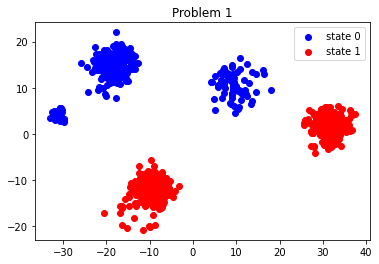

In [7]:
states, obs = sample_gmmhmm(gmmhmm, n_sim=900)

pca = PCA(n_components=2)
new_obs = pca.fit_transform(obs)

plt.scatter(new_obs[states==0, 0], new_obs[states==0, 1], color="blue", label="state 0")
plt.scatter(new_obs[states==1, 0], new_obs[states==1, 1], color="red", label="state 1")
plt.legend(loc='best')
plt.title("Problem 1")
plt.show()

I see three clusters for state 0 and two clusters for state 1.

## Problem 2

Samples.zip contains 30 recordings for each of the words/phrases mathematics, biology, political science, psychology, and statistics. These audio samples are 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. 
Load the recordings into Python using scipy.io.wavfile.read

Extract the MFCCs from each sample using code from the file MFCC.py.
Store the MFCCs for each word in a separate list. You should have five lists, each containing
30 MFCC arrays, corresponding to each of the five words under consideration.

In [ ]:
!unzip Samples.zip -d Samples

!rm Samples/Samples/Biology00.wav
!rm Samples/Samples/Mathematics00.wav
!rm Samples/Samples/PoliticalScience.wav
!rm Samples/Samples/Psychology00.wav
!rm Samples/Samples/Statistics00.wav

In [35]:
bio_list = []
math_list = []
poli_list = []
psych_list = []
stat_list = []
# get ready to store mfccs

In [36]:
path = './Samples/Samples'
for filename in glob.glob(os.path.join(path, '*.wav')):
    samplerate, data = wavfile.read(filename)
    feature = MFCC.extract(data) # extract mfcc coefficients
    if "Biology" in filename:
        bio_list.append(feature)
    elif "Mathematics" in filename:
        math_list.append(feature)
    elif "PoliticalScience" in filename:
        poli_list.append(feature)
    elif "Psychology" in filename:
        psych_list.append(feature)
    elif "Statistics" in filename:
        stat_list.append(feature)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until
/content/MFCC.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot(2,1,1)


In [37]:
print(len(bio_list))
print(len(math_list))
print(len(poli_list))
print(len(psych_list))
print(len(stat_list))

30
30
30
30
30


## Problem 3

Partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.
Using the training sets, train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood). This process may take several minutes. Since you will not want to run this
more than once, you will want to save the best model for each word to disk using the pickle
module so that you can use it later.

In [38]:
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += sp.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + sp.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

In [41]:
# partition train and test data
tr_bio_list = bio_list[10:]
te_bio_list = bio_list[:10]
tr_math_list = math_list[10:]
te_math_list = math_list[:10]
tr_poli_list = poli_list[10:]
te_poli_list = poli_list[:10]
tr_psych_list = psych_list[10:]
te_psych_list = psych_list[:10]
tr_stat_list = stat_list[10:]
te_stat_list = stat_list[:10]

In [43]:
# get ready to store best models
best_bio = None
best_bio_prob = -1000000000000
best_math = None
best_math_prob = -1000000000000
best_poli = None
best_poli_prob = -1000000000000
best_psych = None
best_psych_prob = -1000000000000
best_stat = None
best_stat_prob = -1000000000000

In [46]:
# 
for t in range(10):
    startprob, transmat = initialize(5)
    model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, startprob=startprob, cvtype='diag')
    # these values for covars_prior and var should work well for this problem
    model.covars_prior = 0.01
    model.fit(tr_bio_list, init_params='mc', var=0.1)
    print(model.logprob)
    if model.logprob > best_bio_prob:
        best_bio_prob = model.logprob
        best_bio = model

for t in range(10):
    startprob, transmat = initialize(5)
    model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, startprob=startprob, cvtype='diag')
    # these values for covars_prior and var should work well for this problem
    model.covars_prior = 0.01
    model.fit(tr_math_list, init_params='mc', var=0.1)
    print(model.logprob)
    if model.logprob > best_math_prob:
        best_math_prob = model.logprob
        best_math = model

for t in range(10):
    startprob, transmat = initialize(5)
    model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, startprob=startprob, cvtype='diag')
    # these values for covars_prior and var should work well for this problem
    model.covars_prior = 0.01
    model.fit(tr_poli_list, init_params='mc', var=0.1)
    print(model.logprob)
    if model.logprob > best_poli_prob:
        best_poli_prob = model.logprob
        best_poli = model

for t in range(10):
    startprob, transmat = initialize(5)
    model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, startprob=startprob, cvtype='diag')
    # these values for covars_prior and var should work well for this problem
    model.covars_prior = 0.01
    model.fit(tr_psych_list, init_params='mc', var=0.1)
    print(model.logprob)
    if model.logprob > best_psych_prob:
        best_psych_prob = model.logprob
        best_psych = model

for t in range(10):
    startprob, transmat = initialize(5)
    model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, startprob=startprob, cvtype='diag')
    # these values for covars_prior and var should work well for this problem
    model.covars_prior = 0.01
    model.fit(tr_stat_list, init_params='mc', var=0.1)
    print(model.logprob)
    if model.logprob > best_stat_prob:
        best_stat_prob = model.logprob
        best_stat = model

-33775.33165170406
-33707.749896223
-33853.93303146749
-33095.82668264074
-33798.671985825
-33976.00205615089
-33632.923462757135
-33274.49253819035
-34318.837037579906
-34736.722601598136
-36043.93994346582
-36144.23666529609
-36357.85684108647
-35912.57072515928
-35767.70004277562
-35913.29031406616
-35396.658181059014
-36663.358032949574
-35907.43367342683
-35424.77601150095
-25389.809235901226
-27199.561174538318
-26758.2592101199
-27090.094642287644
-27004.900465141676
-27669.681323339126
-25680.936333625214
-27110.466435842016
-26705.655319136247
-25593.23851120942
-32363.6362039813
-33213.02891683299
-32115.366748267003
-32635.594254297732
-35336.69206651955
-32700.032589375107
-31544.4188383753
-33086.28045960372
-33002.9630625377
-32306.361821087805
-30636.713632445688
-30419.890580302632
-30450.374759676957
-30633.155280603598
-30705.579748740038
-31145.791833813826
-30710.694395671453
-30797.59793350365
-31239.39430799323
-30309.178237874614


## Problem 4

Classify the 10 test samples for each word. Make a dictionary containing the accuracy
of the classification of your five testing sets where the words/phrases are the keys,
and the values are the percent accuracy.

Write a few sentences answering the following questions:
How does your system perform?
Which words are the hardest to correctly classify?

In [58]:
def test_word(word):
    scores = [best_bio.score(word), best_math.score(word),
              best_poli.score(word), best_psych.score(word),
              best_stat.score(word)]
    return np.argmax(scores)

# calculate scores and accuracy

scores = np.array([test_word(i) for i in te_bio_list])
accuracy = len(scores[scores==0])/10

print("Bio Accuracy:", accuracy)

scores = np.array([test_word(i) for i in te_math_list])
accuracy = len(scores[scores==1])/10

print("Math Accuracy:", accuracy)

scores = np.array([test_word(i) for i in te_poli_list])
accuracy = len(scores[scores==2])/10

print("Poli Sci Accuracy:", accuracy)

scores = np.array([test_word(i) for i in te_psych_list])
accuracy = len(scores[scores==3])/10

print("Psych Accuracy:", accuracy)

scores = np.array([test_word(i) for i in te_stat_list])
accuracy = len(scores[scores==4])/10

print("Stat Accuracy:", accuracy)

Bio Accuracy: 0.9
Math Accuracy: 1.0
Poli Sci Accuracy: 0.9
Psych Accuracy: 1.0
Stat Accuracy: 1.0
